In [1]:
# load modules 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
#input raw data
raw_data = pd.read_json('food_enforcement_US_bacteria.json', orient='records')

In [3]:
print(raw_data.shape)
print(raw_data.head(10).product_description)

(6104, 26)
0    Native Catch Salmon Bacon, Traditional flavor....
1    Delish Fruit Burst 10 oz.(283 g)  Enjoy by: 8/...
2    Garden Pure Holiday Fruit Bowl 4 lbs (1.81kg) ...
3    Fresh Fruit Product is labeled in part:  "***F...
4    Ready Pac¿ Gourmet Fruit Bowl, 64oz , UPC 7774...
5    River Ranch brand Diced Grn Cabbage w/Color, 4...
6    Sweet and Sour Stir Fry packaged under the fol...
7    Onion Slab Cut.  Products are labeled in part:...
8    MIX w/yellow onions used as an ingredient.  Pr...
9    Fresh n Easy brand Shred Grn Cabbage w/Color, ...
Name: product_description, dtype: object


### Clean and lemmatize text + TF-IDF vectorize

In [4]:
# class objects
stops = stopwords.words('english')
tfidf = TfidfVectorizer(stop_words = 'english', max_features = 20000)
lemmer = WordNetLemmatizer()

In [5]:
# add stop words after analysis 
stops.extend(('oz', 'upc', 'lb', 'bag', 'package', 'net', 'upc', 'gallon', 'pint', 'ml', 'wei', 'plastic', 
              'com', 'code', 'department', 'wt', 'number', 'industry', 'ia', 'irwindale', 'usa', 'earlier',
             'quart', 'august', 'mamaroneck', 'food', 'imp', 'gl', 'sff', 'description', 'gram', 'weight',
             'brand', 'label', 'fc', 'ounce', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 
              'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh',
              'nj', 'ny', 'nm', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va',
              'wa', 'wv', 'wi', 'wy', 'item', 'pkgs', 'distribute', 'brooklyn', 'lb', 'jefferson', 'dist',
              'beaverton', 'retail', 'determine', 'unable', 'sell', 'snoqualmie', 'gc', 'unit', 'seattle', 'albertson', 
              'kg','cambridge', 'warrensburg', 'op', 'lg', 'rom', 'bentonville', 'chapel', 'hill', 'swainsboro',
              'www', 'iff', 'wei', 'aurora', 'harris', 'bi', 'lo', 'gal', 'qts', 'gh', 'llc','springfield', 'label', 
              'kg', 'po', 'al', 'birmingham','princeton','dz', 'institutional','mb','pleasanton','wei','richfield'
             ))

In [6]:
# Define function get_pos
# Map POS tag to first character lemmatize() accepts

def get_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

In [7]:
# Define function kleenex
# Cleans, lemmatizes, and removes stop words 

def kleenex(d):
    tmp = []
    for t in d:
        if type(t) == str:
            w = re.sub("[^A-Za-z]+", " ", t) # remove non-letters
            w = w.lower() # lower class
            w = w.strip() # remove spaces
            w = word_tokenize(w) # tokenize words
            w = [lemmer.lemmatize(wrd, get_pos(wrd)) for wrd in w if wrd not in stops] #lemmatize word
            w = " ".join(w)
            tmp.append(w)
        #else:
        #    tmp.append(None)
    return(tmp)

In [8]:
# Build corpus
corpus = raw_data['product_description']

# Clean Corpus
X = kleenex(corpus)

In [9]:
# TF-IDF transformation
Xtrans = tfidf.fit_transform(X)

# get tf idf feature names 
words = tfidf.get_feature_names()

# tf-idf shape
Xtrans.shape


(6104, 5201)

### fit Kmeans and find optimal number of clusters

In [14]:
# fitting K means to view change in Inertia
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# container to store inertia scores over iterations
distortions = []
NCs = (10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200)
km = {}
silhouette_coef = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(20):
    km[i] = KMeans(n_clusters=NCs[i], n_init=20)
    km[i].fit(Xtrans)
    distortions.append(km[i].inertia_)
    score = silhouette_score(Xtrans, km[i].labels_)
    silhouette_coef.append(score) 

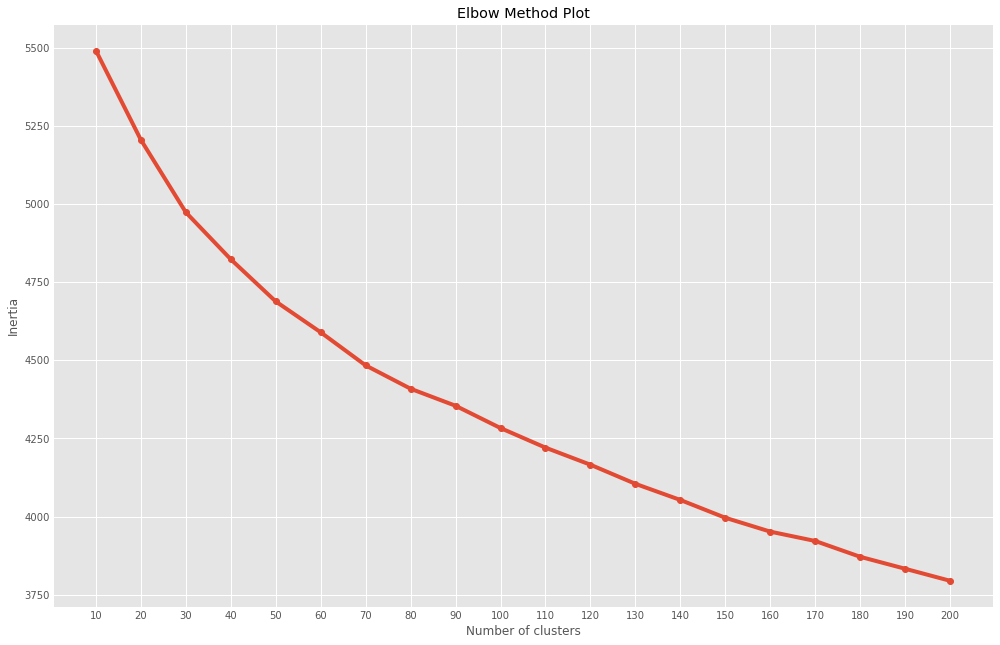

In [15]:
# vizualize change in inertia
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.plot(range(20), distortions, marker='o')
plt.title('Elbow Method Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(20), NCs)
plt.show()

In [16]:
# locate the elbow

from kneed import KneeLocator

kl = KneeLocator(NCs, distortions, curve="convex", direction="decreasing")

kl.elbow


70

### Plot Silhouette score

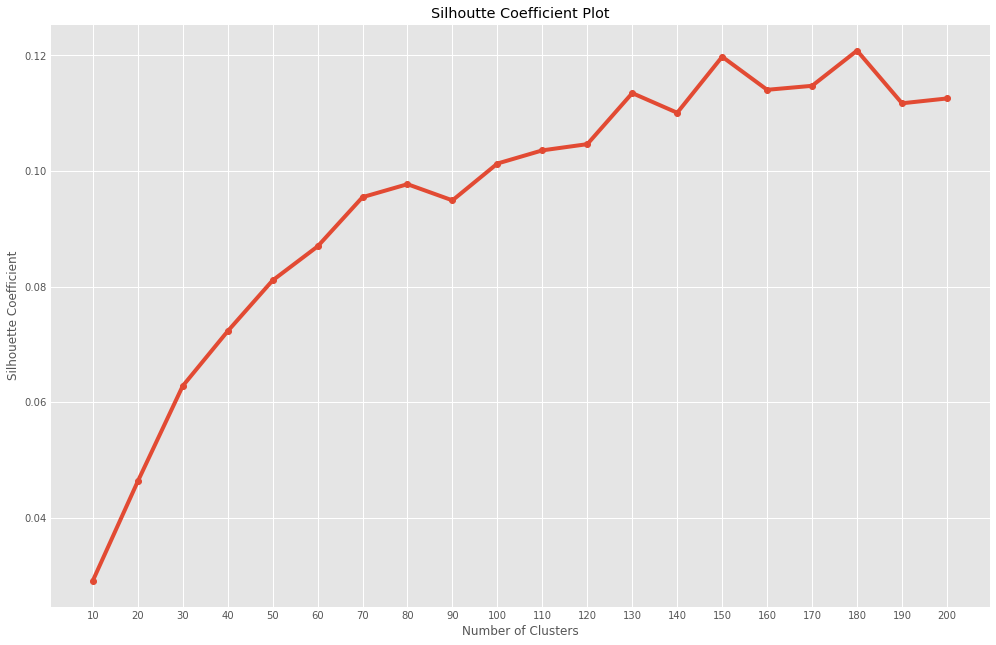

In [18]:

plt.figure(figsize=(15,10))

plt.plot(range(20), silhouette_coef, marker='o')
plt.title('Silhoutte Coefficient Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.xticks(range(20), NCs)
plt.show()


### labels are named with integers and stored in the `labels_` attribute

In [19]:
km[6].labels_

array([ 6, 42, 42, ..., 50, 42, 42])

### take a look at one of the cluster results

In [50]:
# You should look at all the clusters, but let's look at cluster "15" (I chose this arbitrarily; you should look at all of them)

n=14
cluster=144

for i in range(0,len(km[n].labels_)):
    if km[n].labels_[i] == cluster:
        print(raw_data['product_description'][i])
        print('**********')

Sprouts, Natto Soybean, packed in clear plastic 1.0 lb bags, labeled in part *** Henry's Farm Inc. 5500 Fair Oak Lane, Woodward, VA 22580*** 
**********
Banner Mountain Sprouts;Alfalfa Broccoli Sprouts;  California Certified Organic Sprouts.  100% certified organic seeds used.  Sacramento, Ca 95820.    Net Wt. 4 oz; Rinse and Eat; Perishable, Keep refrigerated.  UPC  4 oz size: 0- 9691172840 9;   
**********
Banner Mountain Sprouts; Clover Sprouts:  California Certified Organic Sprouts.  100% certified organic seeds used.  Sacramento, Ca 95820.    Net Wt. 4 oz and 1 lb containers; Rinse and Eat; Perishable, Keep refrigerated.  UPC  4 oz size: 0- 96911 72843 0;   UPC - 1 lb size: 0 96911 72851 5.
**********
Sprouts, Soybean, packed in clear plastic 1.0 lb and 1.5 lb. bags, labeled in part *** Henry's Farm Inc. 5500 Fair Oak Lane, Woodward, VA 22580*** and also bulk packaged in unlabeled 10 lb black plastic bags.
**********
Organic traditions SPROUTED FLAX SEED POWDER, NET WT. 8 oz/227g,

### Examine top 10 common words by cluster

In [54]:
# Set the top 10 common words in K Means cluster centers 
common_words = km[14].cluster_centers_.argsort()[:,-1:-11:-1]

# print out the results by the 250 clusters 
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : pack, groove, variety, code, french, cookie, single, gluten, sandwich, free
1 : curry, chicken, salad, sell, wrap, right, make, rollup, glass, ppk
2 : batch, package, firm, cardboard, tub, container, ice, product, cream, italian
3 : carton, case, formula, package, potato, salad, distribute, safeway, counter, sysco
4 : cream, ice, gum, husky, milk, half, bulk, lecithin, skim, carrageenan
5 : polyethylene, ranch, river, polypropylene, consume, foodservice, product, film, process, best
6 : tray, safeway, store, cup, clear, sell, packed, vegetable, dip, veggie
7 : sunland, peanut, butter, portales, creamy, produce, organic, crunchy, natural, valencia
8 : cabbage, cranberry, walnut, garden, fresh, red, relish, shred, piece, ambrosia
9 : frozen, fresh, grade, food, blend, pea, cut, biscuit, bean, green
10 : chocolate, asher, milk, cluster, dark, box, almond, coat, flavor, paw
11 : smoke, salmon, oyster, vacuum, coho, locate, gnupharma, king, sell, capsule
12 : product, package, case, lb,

### Plot histogram to see distribution by labels 

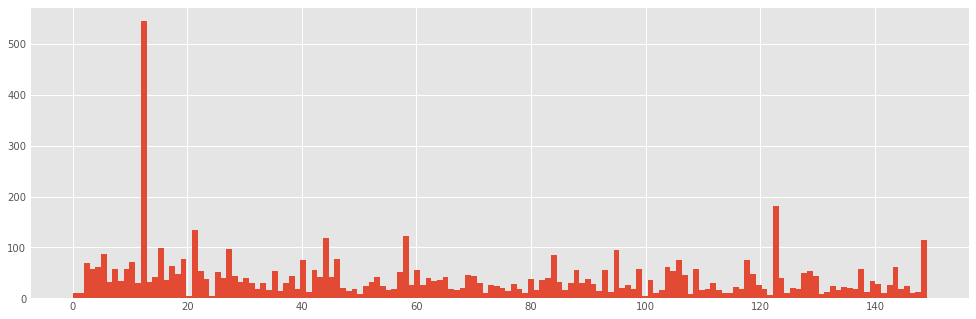

In [53]:
plt.figure(figsize=(15,5))

plt.hist(km[14].labels_, density=False, bins=150)
plt.show()

# Summary of Work and Results 

### Data cleaning and Initial Clustering 

I first carried out data cleaning of the text by removing stop-words, non-letters and spaces, lower-case trasnforming, tokenizing and then lemmatizing the words for analysis. The corpus was then analyzed with the TFIDFVectorizer from scikit learn. With these features, I carried out KMeans clustering with number of clusters from 2 to up to 400. The result showed that there were no clear elbow in the inertia plot where the inertia rates continue to gradually decrease with the increase in number of clusters. However, with more clusters, the clustering becomes inefficient and impractical for use. 

After the first pass, I also recongized that there were a number of words that were common but not specifically relevant for the clustering by food categories. These included weight figures such as 'oz', 'lbs' or location and state names and others. Hence, I added these to the stop-word list to remove in the data cleaning stage. 

### KMeans cluster optimization

As for the number of clusters, I decided to find the optimum value from 10 to 200 to make the clusters practical. To check the results, I used the Elbow Plot and Silhoutte Scores to find the optimum number. Based on the KneeLocator, the knee is suggested at 70, which is a managable number of food categories. The clustering result is also quite good with most clusters having coherent grouping of similar food categories. However, there seems to be a cluster that contains a number of non-classified items which is quite large with over 1,500 items. Considering this is almost 25% of the total number of items, I was not fully satisified with 70 clusters. 

Using the silhoutte coefficient plot, I look at the consistency of the clusters. The plot shows that the silhoutte scores continue to improve overall with the number of clusters up. However, it seems to plateau at around 150 clusters. This also seems to be a more practical number compared to 180 clusters that has a slightly higher silhoutte coefficient, but more clusters to analyze. Hence, I decided to use 150 clusters with n_init=20 for the final KMeans model. 

### Clustering Results and Examples

The clustering using the final model works well with all most all clusters that have cohesive food categories within the clusters. You can see a couple of examples of clusters having cohesive classification. Howver, there does seem to be some overlap between clusters as suggested by the relatively low silhoutte coefficient. For instance, there are a number of ice cream clusters although slightly different by type, product or company, as seen in the top 10 common words per cluster analysis. Other than this, there also continues to be a left-over cluster, where non-classifiable items are dumpped. However, the size the cluster has decreased to around 550 items or so. Looking at the items for this cluster (cluster: 12, below), there does seem to be difficulties in clusters considering that they tend to have very short descriptions and use vague language that are difficult to associate with other clusters. Considering this along with the fact that increasing the cluster number more might not be practical and rather make the clustering un-usable, I would propose to keep the 150 cluster as the final version of this exercise. 

### Examples of the Clustering Results

**Cluster: 0 (Ice Cream type)**
>Groove Gluten-Free Dark Chocolate Cookie & French Vanilla Ice Cream Sandwich.  The product is sold in 3 fl. oz. single packs and 6 fl. oz. 2-packs and labeled as Groove.      The UPC codes are 8 52692 00405 3 and  8 52692 00403 9.  
>**********
>Groove Gluten-Free Dark Chocolate Cookie & French Chocolate Ice Cream Sandwich.  The product is sold in 3 fl. oz. single packs and 6 fl. oz. 2-packs and labeled as Groove.      The UPC codes are 8 52692 00406 0 and 8 52692 00403 2
>**********
>Chocolate Covered Vanilla Ice Cream Bars packaged under the following brands: 12 packs - Ahold  UPC: 6 88267 03323 5 and different ICB: 6 88267 08587 1, Econo  UPC: 7 08938 00534 9, First Street  UPC: 0 41512 11933 0, Food Club  UPC: 0 36800 78404 8, Giant Eagle  UPC: 0 30034 00329 6, Great Value  UPC: 0 78742 09158 7, Greens  UPC: 0 71441 03131 1, Hagan no ICBs, Hood  UPC: 0 44100 23704 1, Kroger  UPC: 0 11110 57120 5 and Kroger NFA ICBs  UPC: 0 11110 57885 3, Lucerne  UPC: 0 21130 09799 9, Market Basket  UPC: 0 49705 96902 1, Party Treat No ICBs, PIC  no product of ours, Polar Express  Only Variety pack, Price Chopper  UPC: 0 41735 09260 1, Price Rite  UPC: 0 41190 75712 1, Purple Cow  UPC: 7 08820 42754 9, Shoprite  UPC: 0 41190 40126 0, Southern Home  UPC: 6 07880 01147 0, , Stater  UPC: 0 74175 85045 6, Stoneridge  UPC: 0 41130 61333 3, Sundae Shoppe  UPC: 0 41498 17991 5, Tops  UPC: 0 70784 04912 0, United Dairy  UPC: 0 71580 08079 9, Weis  UPC: 0 41497 01042 4, Wellsley Farms   Only Variety pack, Winn Dixie  UPC: 0 21140 27145 7, World s Fair  UPC: 0 51933 67170 6


**Cluster: 78 (Soup type)**
>Small Soup Vegetable Mix:-(Item #CC4)  Spanish Onions {1/4" dice), Carrots, Celery  Medium Soup Mix Vegetables (Item #CC5)  Spanish Onions (1/2" dice), Carrots. Celery  5 lb poly bags  Packed by: Fresh Ideas Co., 18 Bunker Hill Industrial Park, Boston, MA 02129  Item # 00254
>**********
>#023  Soup Starter	8 ounces  
>**********
>CULINARY Creations (brand) CHEESY BROCCOLI SOUP, 3F3080, CONTAINS: 20/2 LB. CHUBS, NET WT. 40 LBS. 91816 KG), DIVERSIFIED FOODS AND SEASONINGS, INC, 1115 N. CAUSEWAY BLVD. STE.200, MANDEVILLE, LA 70471 1-800-835-3374, FOR INSTITUTIONAL USE ONLY,  UPC 00732628330803
>**********
>Garden-Fresh,	Soup Mix 3/4".,	2/5 lb,..		0 11596 50763 7,	             10/31/2103 - 11/8/2013;  


**Cluster: 144 (Sprouts type)**
>Banner Mountain Sprouts; Clover Sprouts:  California Certified Organic Sprouts.  100% certified organic seeds used.  Sacramento, Ca 95820.    Net Wt. 4 oz and 1 lb containers; Rinse and Eat; Perishable, Keep refrigerated.  UPC  4 oz size: 0- 96911 72843 0;   UPC - 1 lb size: 0 96911 72851 5.
>**********
>Sprouts, Soybean, packed in clear plastic 1.0 lb and 1.5 lb. bags, labeled in part *** Henry's Farm Inc. 5500 Fair Oak Lane, Woodward, VA 22580*** and also bulk packaged in unlabeled 10 lb black plastic bags.
>**********
>Organic traditions SPROUTED FLAX SEED POWDER, NET WT. 8 oz/227g, UPC 854260006261 --- The product is packed in a sealed flexible plastic bag.
>**********
>Organic traditions SPROUTED CHIA & FLAX SEED POWDER, NET WT. 8 oz./227g (UPC barcode 854260006216), and NET WT. 16oz./454g bag (UPC barcode 85426000547) --- The product is packed in a sealed flexible plastic bag.


**Cluster: 12 (Left-overs)** 
 
>UNH Stir Fry: 5 lbs ply bag   Broccoli. Bock Choy. Spanish Onions (1" x 1" cut). Celery  Packed by: fresh Ideas Co., 18 Bunker Hill Industrial Park, Boston, MA 02129  Item # 00137
>**********
>Protein Shots, Orange Sunshine Flavor, 2.9 fl oz (Responsible firm on label: Body Choice Nutrition, Inc., 1595 Peachtree Park Way, Suite 204, Cumming, GA  30041)
>**********
>ProBalance Protein To Go(TM), Milk Chocolate Shake, Dietary Supplement, Net Wt 2.5 fl oz  (Responsible firm on labeling:  Pro Balance LLC, 4070 Tampa Road, Oldsmar, FL  34677)
> **********
>ALFALFA SEED, NET WT. 50 LB. International Specialty Supply LLC, Cookeville, TN
> **********
>Turkey Dripping Type Marinade X1, 50 lb. bags, Manufactured by Newly Weds Foods, Chicago, IL 60639, product G00988 
